<a href="https://colab.research.google.com/github/joshwa17sijuthomas/2Dto3D/blob/main/LabProject_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [1]:
import anvil.server

anvil.server.connect("server_XDBLRWVSJZCVINH6S6E5YGKR-DYNAAZRSLOQAEAB4")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [20]:
#importing the libraries
import torch
import sys
import os
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        pytVersionStr=torch.__version__.split("+")[0].replace(".", "")
        versionStr="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pytVersionStr}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{versionStr}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from pytorch3d.io import save_obj,load_objs_as_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.loss import mesh_edge_loss
from pytorch3d.loss import mesh_laplacian_smoothing
from pytorch3d.loss import mesh_normal_consistency
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.renderer import look_at_view_transform
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.renderer import PointLights
from pytorch3d.renderer import DirectionalLights
from pytorch3d.renderer import Materials
from pytorch3d.renderer import RasterizationSettings
from pytorch3d.renderer import MeshRenderer
from pytorch3d.renderer import MeshRasterizer
from pytorch3d.renderer import SoftPhongShader
from pytorch3d.renderer import SoftSilhouetteShader
from pytorch3d.renderer import SoftPhongShader
from pytorch3d.renderer import TexturesVertex



In [5]:
dev = torch.device("cuda:0")
torch.cuda.set_device(dev)

In [27]:
folder_path = './color'

os.makedirs(folder_path, exist_ok=True)

number_of_images = 8

elevation = torch.linspace(0,360, number_of_images)
azimuth = torch.linspace(-180,180, number_of_images)


pointlights = PointLights(device=dev, location=[[0.0, 0.0, -3/10]])


Rotation, Translation = look_at_view_transform(dist=27/10, elev=elevation, azim=azimuth)


cam = FoVPerspectiveCameras(device=dev, R=Rotation[None, 1, ...],
                                  T=Translation[None, 1, ...])

targetcameras = [FoVPerspectiveCameras(device=dev, R=Rotation[None, j, ...],
                                           T=Translation[None, j, ...]) for j in range(number_of_images)]

sigmavariable = 0.0001
raster_silhouette = RasterizationSettings(
    image_size=128,
    faces_per_pixel=50,
    blur_radius=np.log(1. / 0.0001 - 1.)*sigmavariable,
)

silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cam,
        raster_settings=raster_silhouette
    ),
    shader=SoftSilhouetteShader()
)

In [10]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2024-04-13 08:51:00--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-04-13 08:51:00 (25.7 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [34]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import anvil.media

@anvil.server.callable
def save(image,name):
  from PIL import Image

  with anvil.media.TempFile(image) as image:
    print(name)
    img = Image.open(image)
    img.save("./color/"+name)

  return "done"

In [45]:
@anvil.server.callable
def Generator():
  folder_path = "./color/"
  from PIL import Image
  images = []
  for filename in sorted(os.listdir(folder_path)):
      if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
          img = Image.open(folder_path+filename)
          images.append(img)
  from torchvision import transforms
  transform = transforms.Compose([
      # transforms.Resize((256, 256)),  # Resize image
      transforms.ToTensor(),           # Convert image to tensor
  ])

  target_rgb = []
  for img in images:
    tensor_image = transform(img)
    tensor_image_cuda = tensor_image.to('cuda')
    tensor_image_cuda = tensor_image_cuda.permute(1,2,0)
    target_rgb.append(tensor_image_cuda)
  combined_tensor_color = torch.stack(target_rgb)
  image_grid(combined_tensor_color.cpu().numpy(), rows=2, cols=4, rgb=True)
  plt.show()
  silimages = []

  for img in images:
      image = img
      inverted_image = Image.eval(image, lambda x: 255 - x)
      grayscale_image = inverted_image.convert("L")

      bw_image = Image.new("L", grayscale_image.size, 0)

      for x in range(grayscale_image.width):
          for y in range(grayscale_image.height):
              if grayscale_image.getpixel((x, y)) > 10:
                  bw_image.putpixel((x, y), 255)

      silimages.append(bw_image)
  target_silhouette = []

  for img in silimages:
    tensor_image = transform(img)
    tensor_image_cuda = tensor_image.to('cuda')
    tensor_image_cuda = tensor_image_cuda[0]
    target_silhouette.append(tensor_image_cuda)
  combined_tensor_sil = torch.stack(target_silhouette)
  expanded_combined_tensor_sil = combined_tensor_sil.unsqueeze(3)
  expanded_combined_tensor_sil = expanded_combined_tensor_sil.repeat(1,1,1,4)
  image_grid(expanded_combined_tensor_sil.cpu().numpy(), rows=2, cols=4, rgb=False)
  plt.show()
  def visualize_prediction(predicted_mesh, renderer=silhouette_renderer,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

  def plot_losses(losses):
      fig = plt.figure(figsize=(13, 5))
      ax = fig.gca()
      for k, l in losses.items():
          ax.plot(l['values'], label=k + " loss")
      ax.legend(fontsize="16")
      ax.set_xlabel("Iteration", fontsize="16")
      ax.set_ylabel("Loss", fontsize="16")
      ax.set_title("Loss vs iterations", fontsize="16")
  src_mesh = ico_sphere(4, dev)
  num_views_per_iteration = 3
  Niter = 2000
  plot_period = 250

  %matplotlib inline

  losses = {"silhouette": {"weight": 1.0, "values": []},
            "edge": {"weight": 1.0, "values": []},
            "normal": {"weight": 0.01, "values": []},
            "laplacian": {"weight": 1.0, "values": []},
          }

  def update_mesh_shape_prior_losses(mesh, loss):
      loss["edge"] = mesh_edge_loss(mesh)

      loss["normal"] = mesh_normal_consistency(mesh)

      loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")


  verts_shape = src_mesh.verts_packed().shape
  deform_verts = torch.full(verts_shape, 0.0, device=dev, requires_grad=True)

  optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
  loop = tqdm(range(Niter))

  for i in loop:
      optimizer.zero_grad()

      new_src_mesh = src_mesh.offset_verts(deform_verts)

      loss = {k: torch.tensor(0.0, device=dev) for k in losses}
      update_mesh_shape_prior_losses(new_src_mesh, loss)


      for j in np.random.permutation(number_of_images).tolist()[:num_views_per_iteration]:
          images_predicted = silhouette_renderer(new_src_mesh, cameras=targetcameras[j], lights=pointlights)
          predicted_silhouette = images_predicted[..., 3]
          loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
          loss["silhouette"] += loss_silhouette / num_views_per_iteration

      sum_loss = torch.tensor(0.0, device=dev)
      for k, l in loss.items():
          sum_loss += l * losses[k]["weight"]
          losses[k]["values"].append(float(l.detach().cpu()))


      loop.set_description("total_loss = %.6f" % sum_loss)

      if i % plot_period == 0:
          visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                              target_image=target_silhouette[1])

      sum_loss.backward()
      optimizer.step()
  visualize_prediction(new_src_mesh, silhouette=True,
                       target_image=target_silhouette[1])
  plot_losses(losses)
  final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)


  final_obj = os.path.join('./', 'output.obj')
  save_obj(final_obj, final_verts, final_faces)
  from google.colab import files

  import shutil
  colab_file_path = './output.obj'
  drive_folder_path = '/content/drive/My Drive/objfile/'

  # Copy the file from Colab to Drive
  shutil.copy(colab_file_path, drive_folder_path)

  return "https://drive.google.com/drive/u/0/folders/1hHRwoLQRmiWm3BKhnhXOJXfKLNixuFdS"


'/content/drive/My Drive/objfile/plane2.obj'

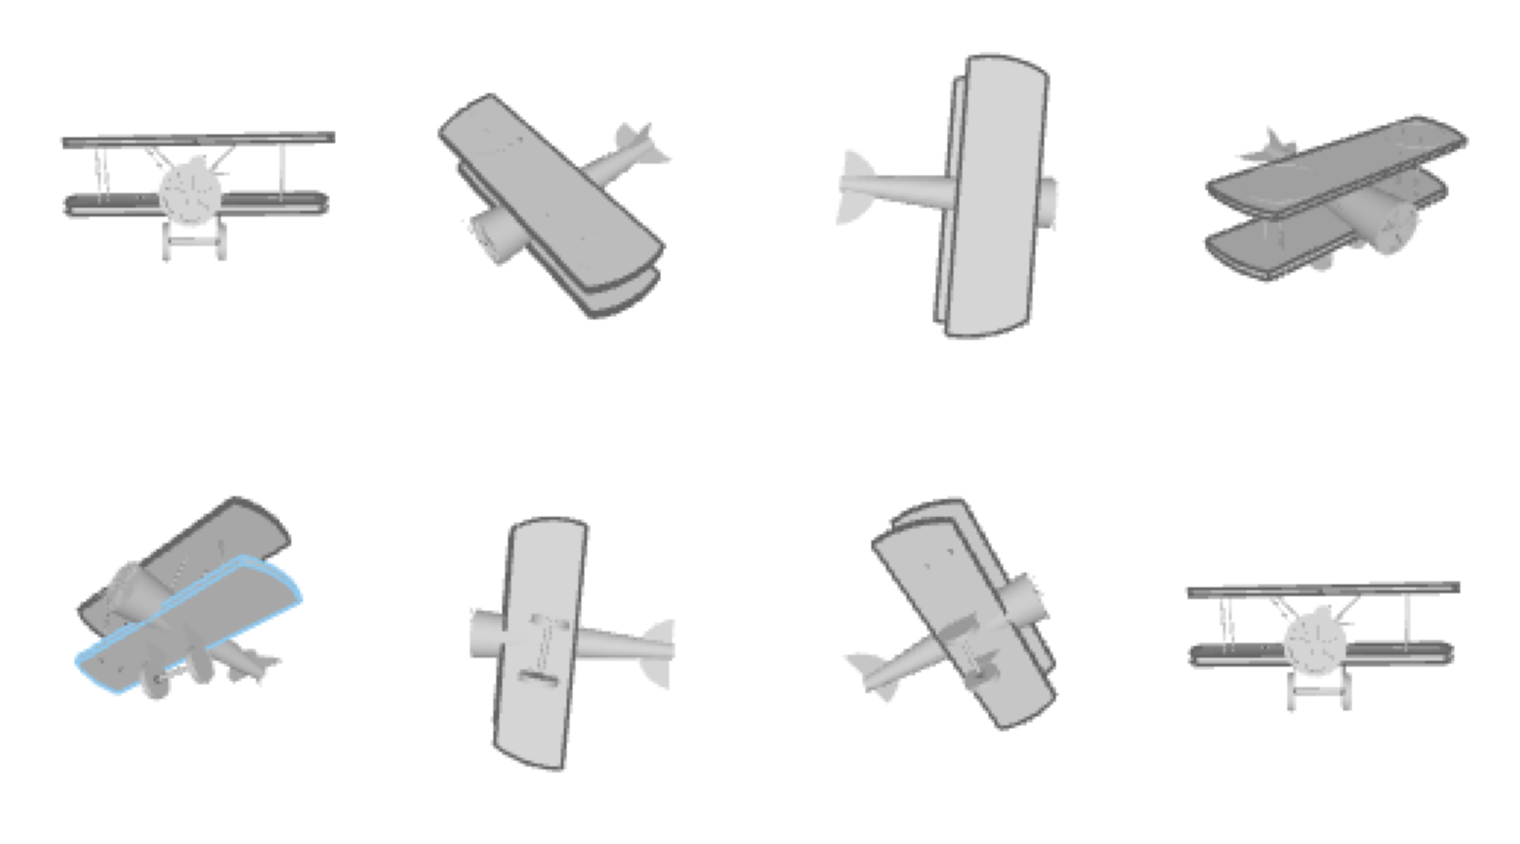

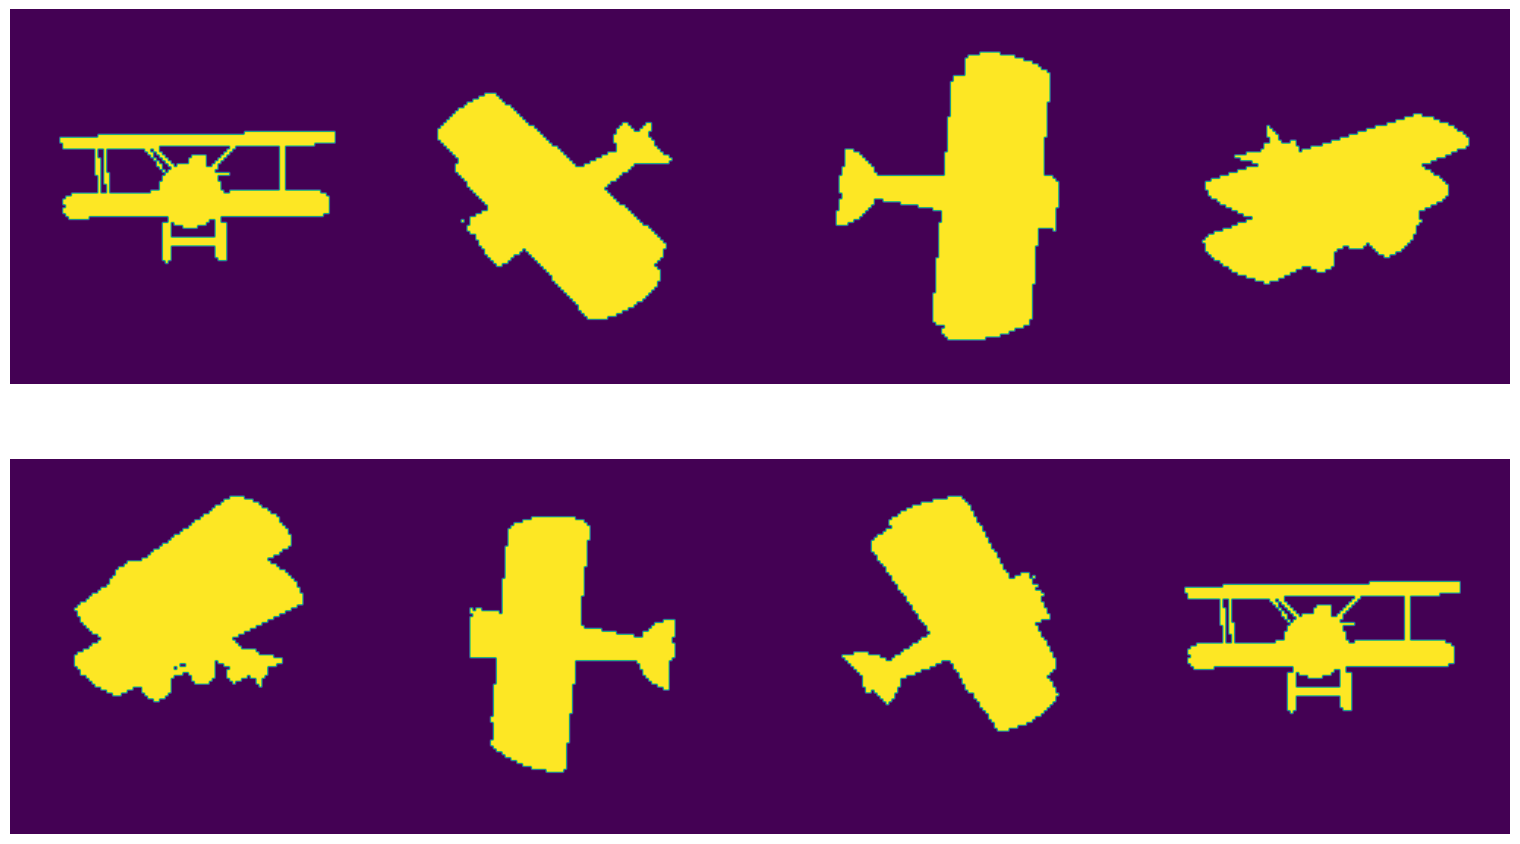

  0%|          | 0/2000 [00:00<?, ?it/s]

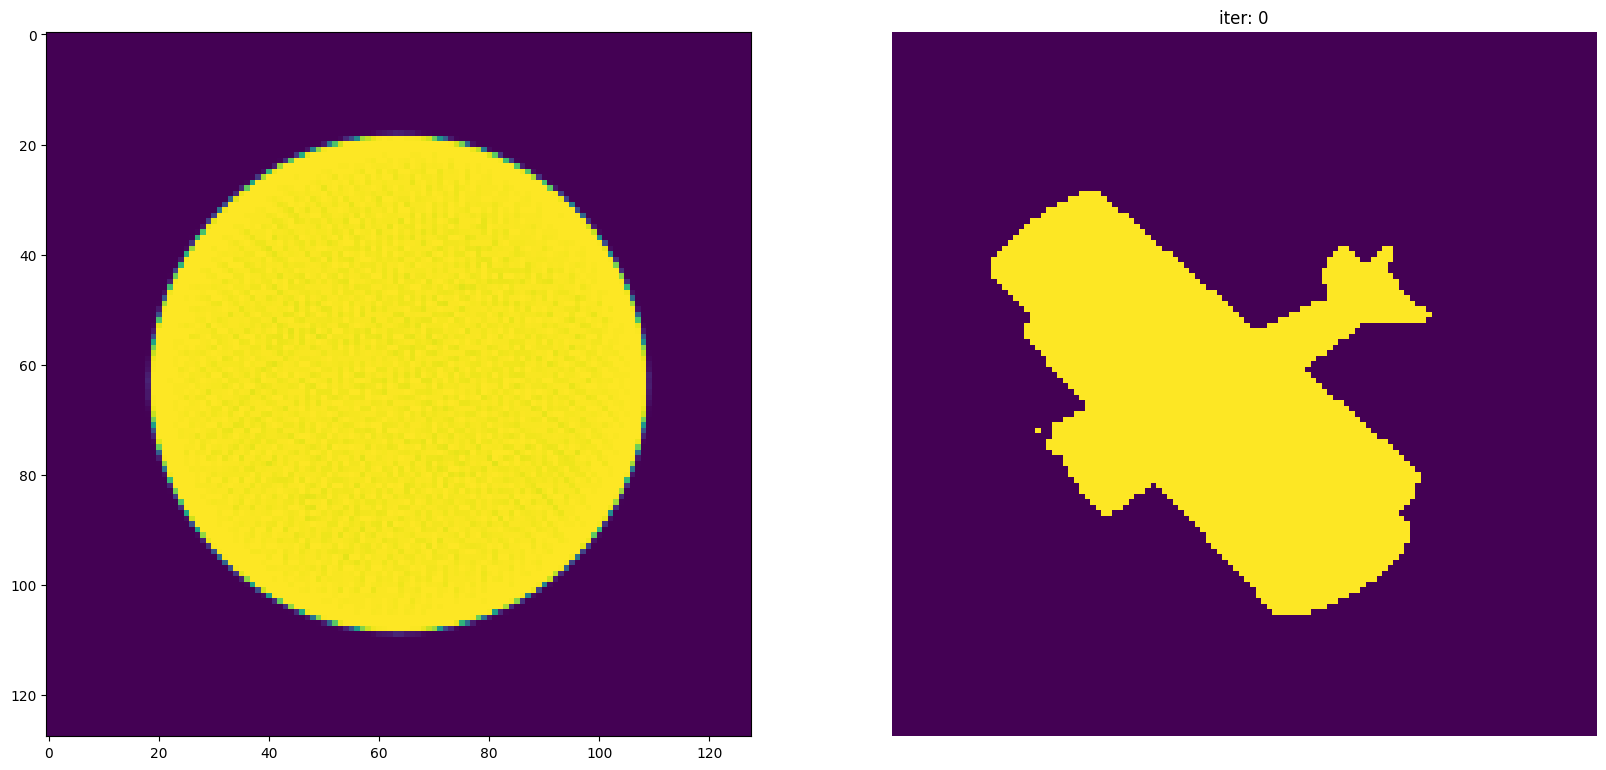

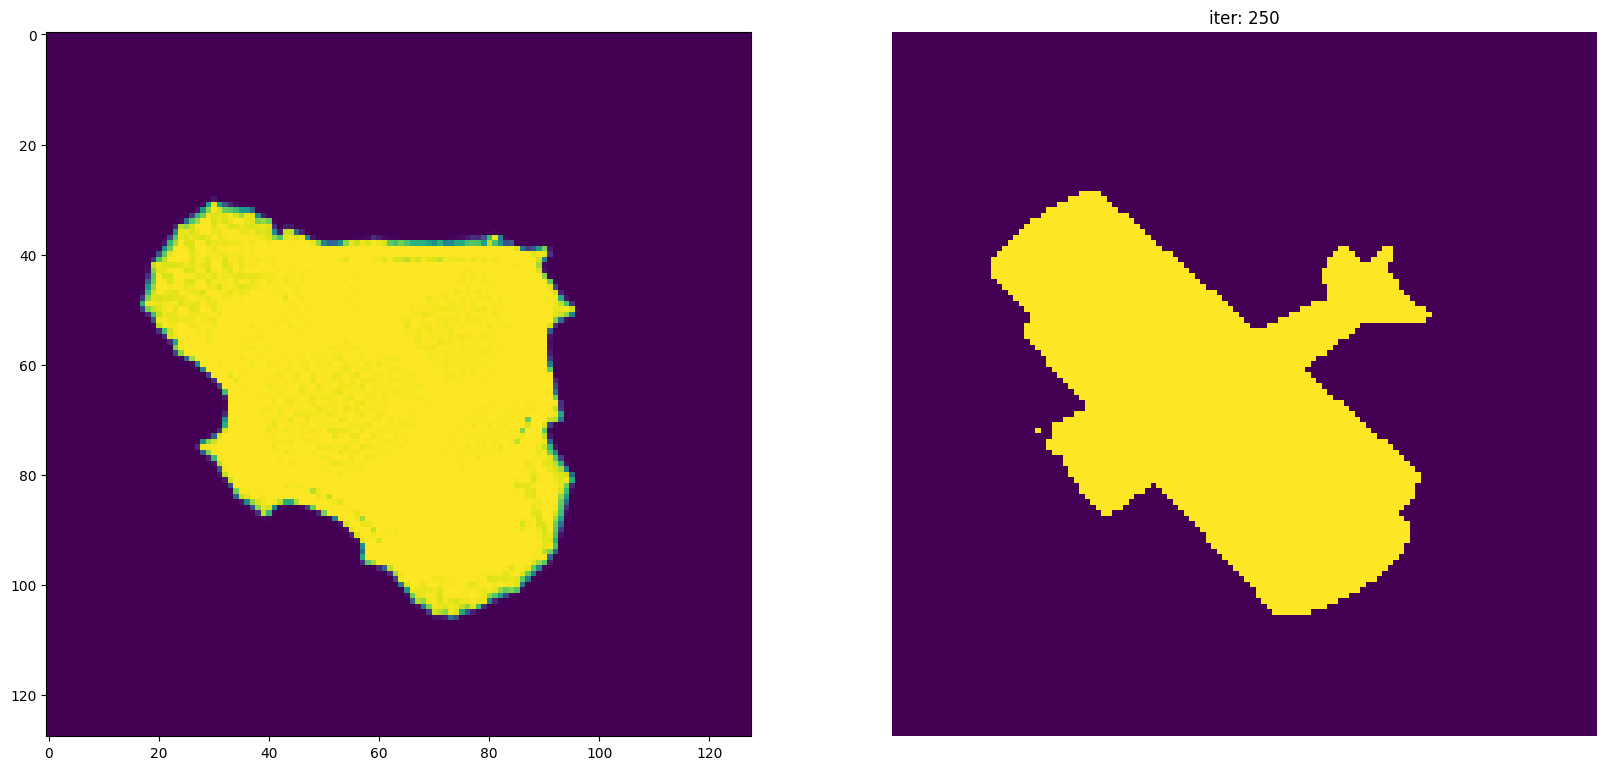

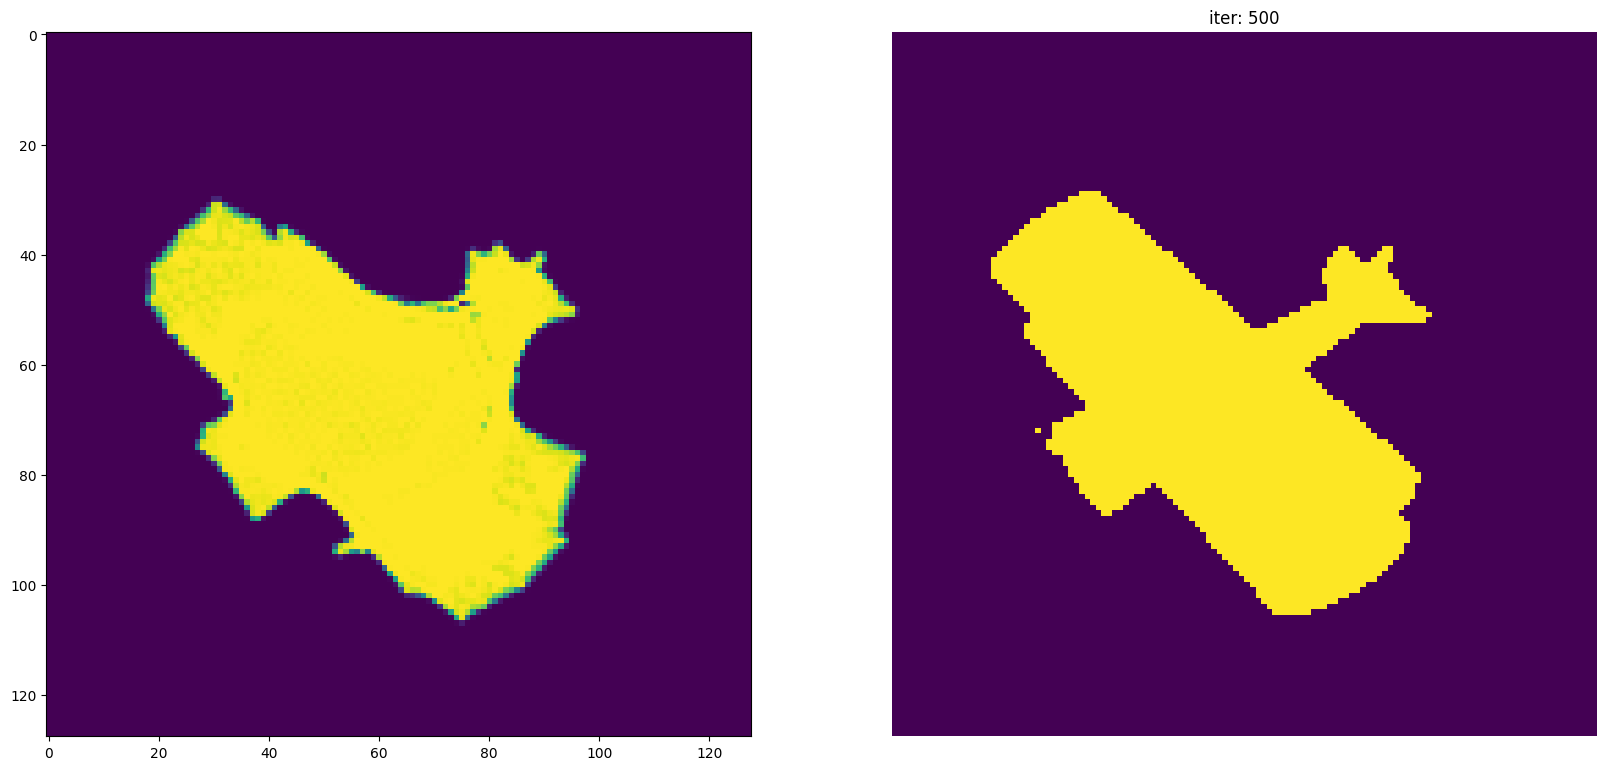

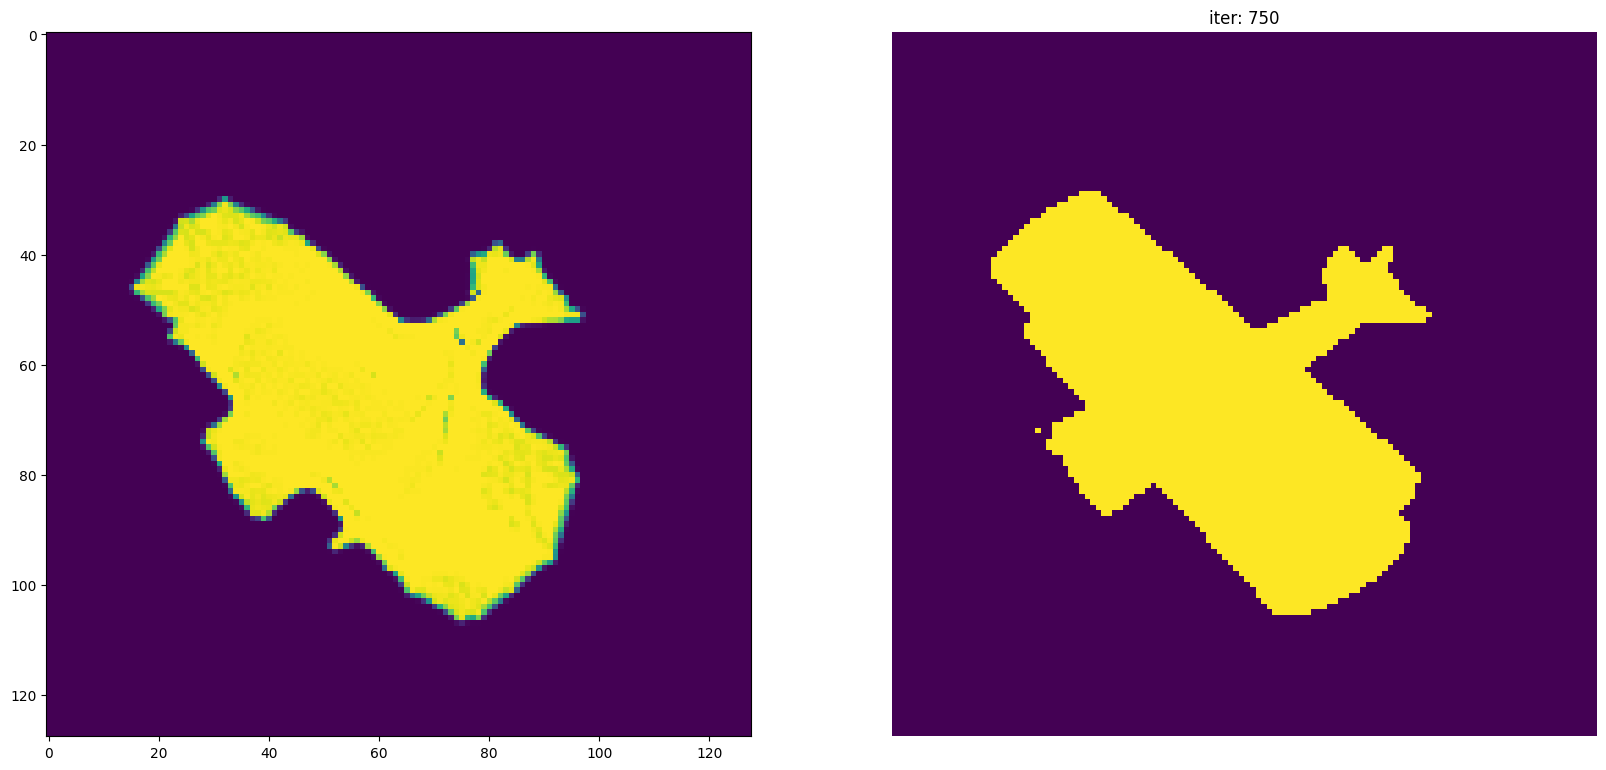

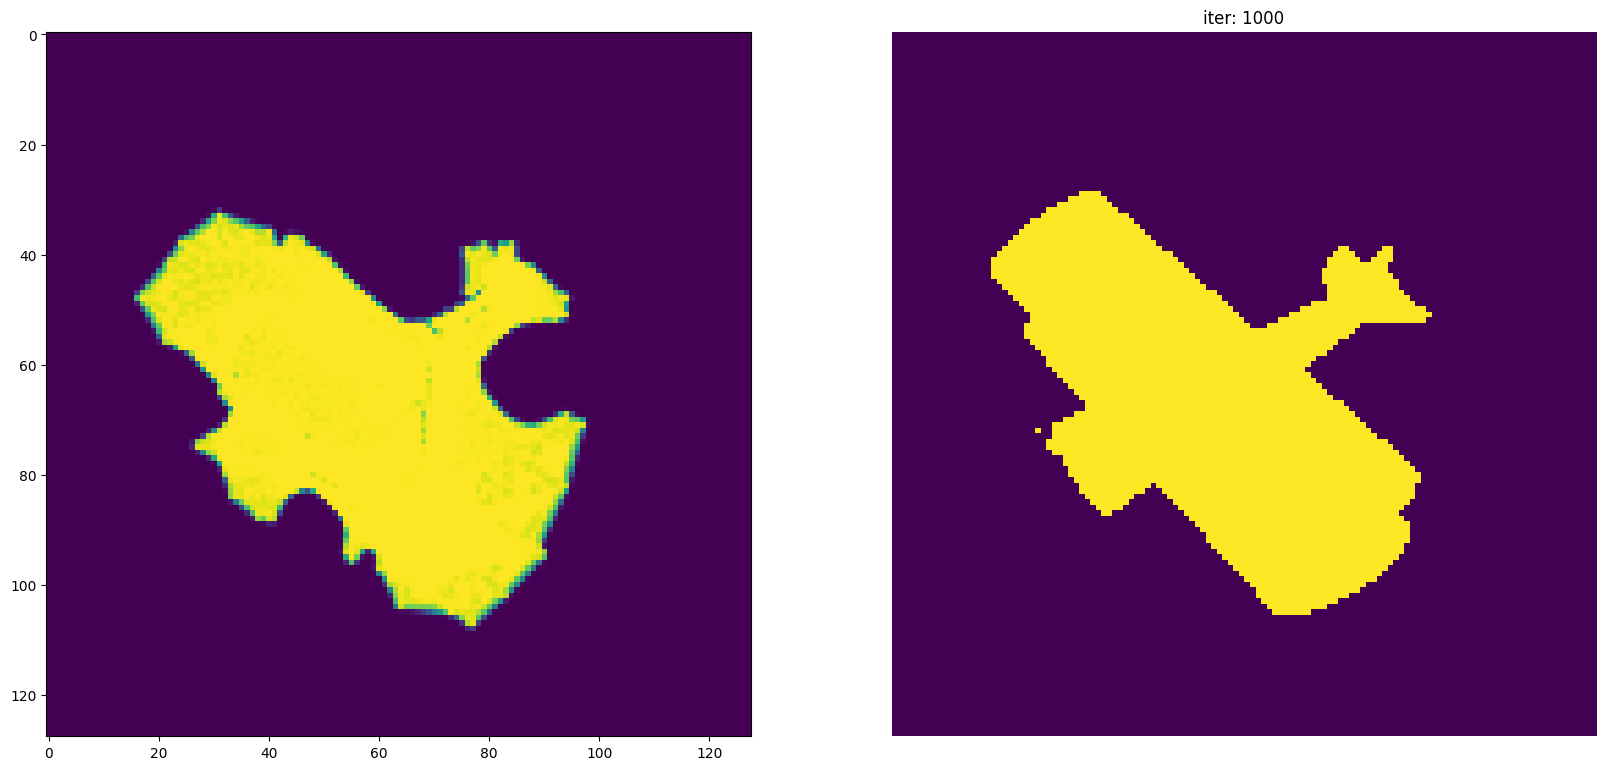

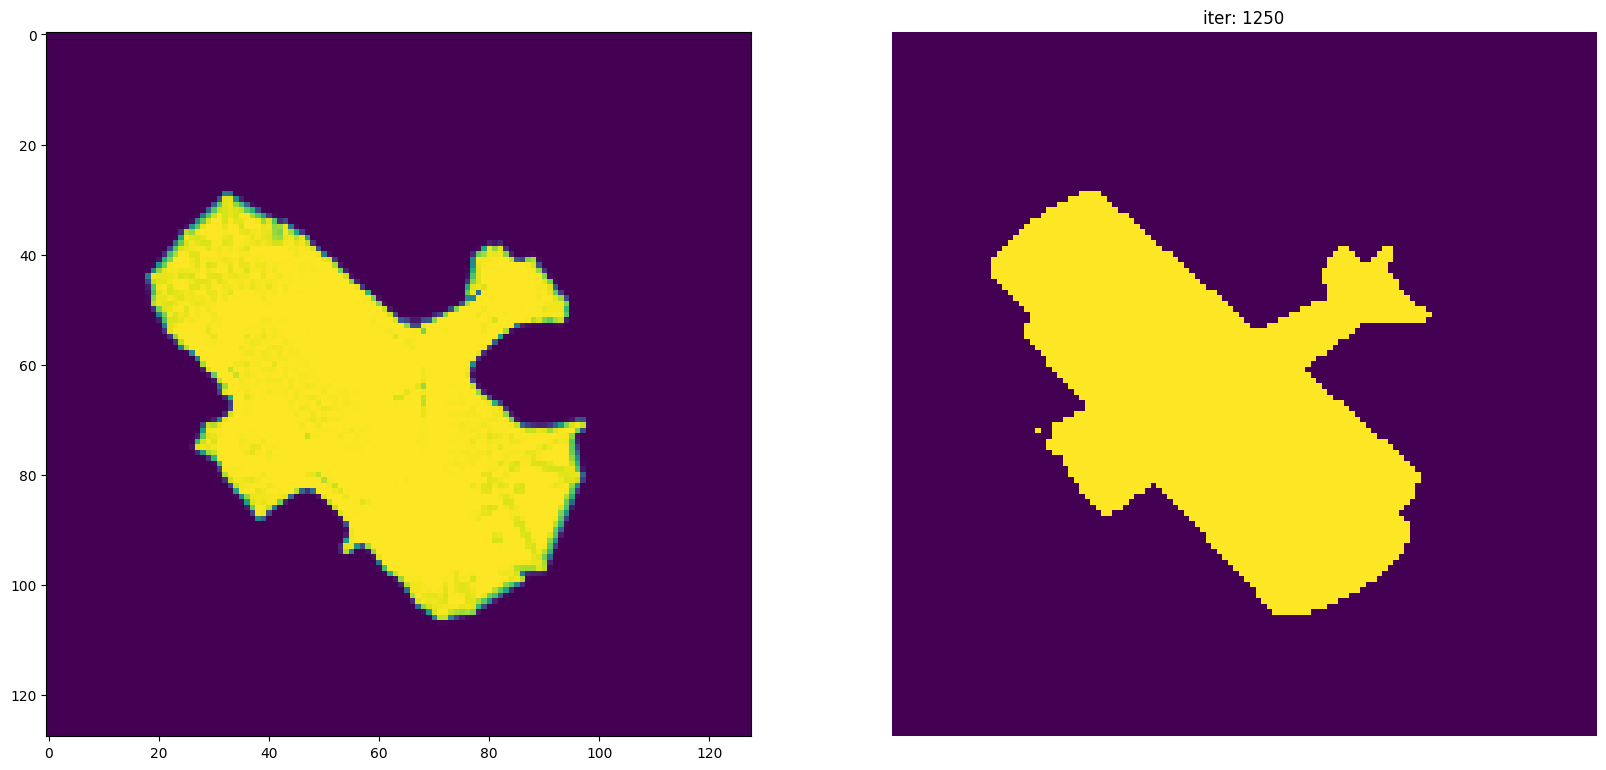

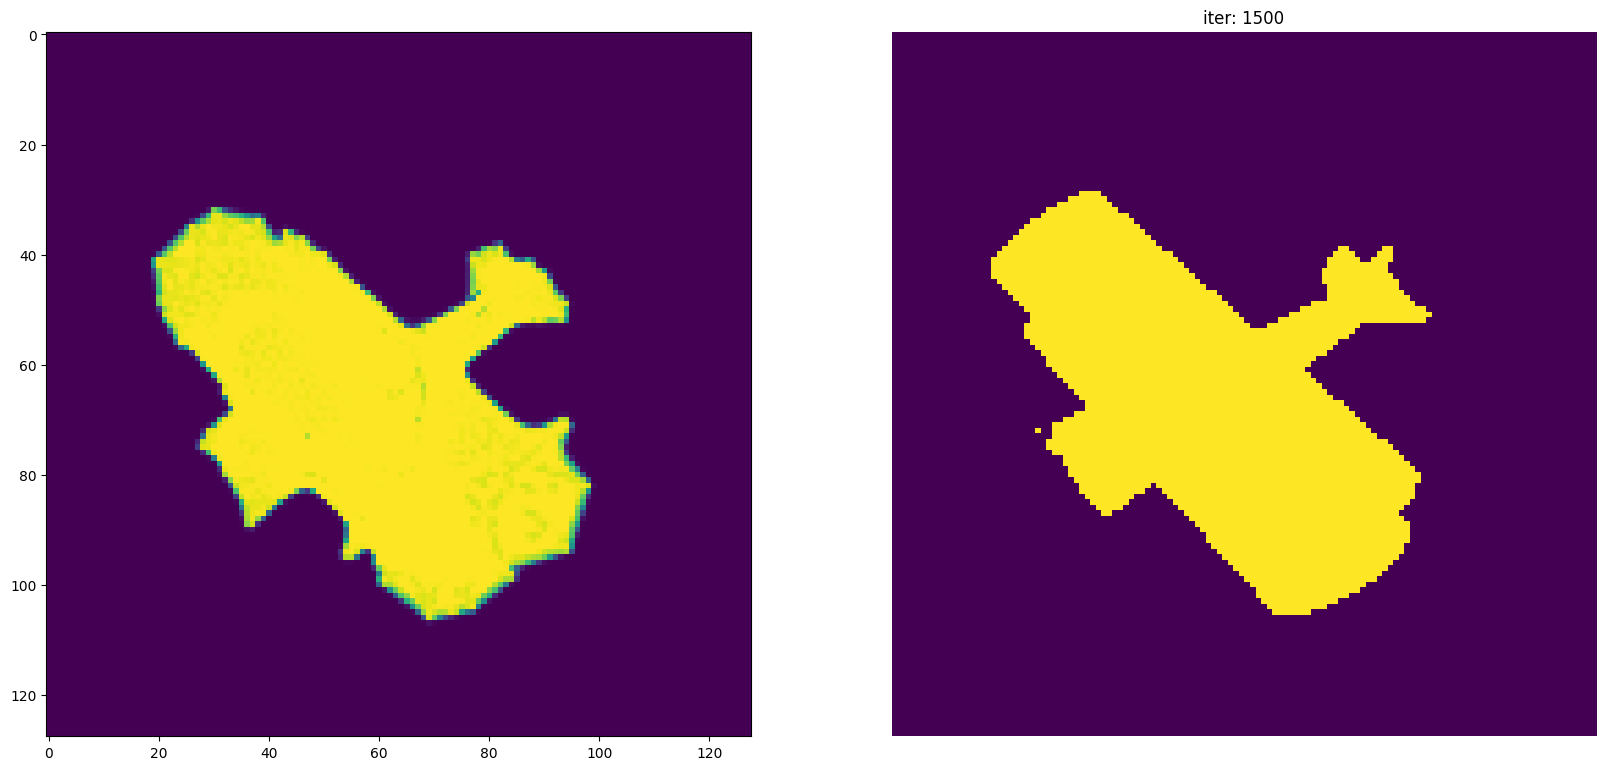

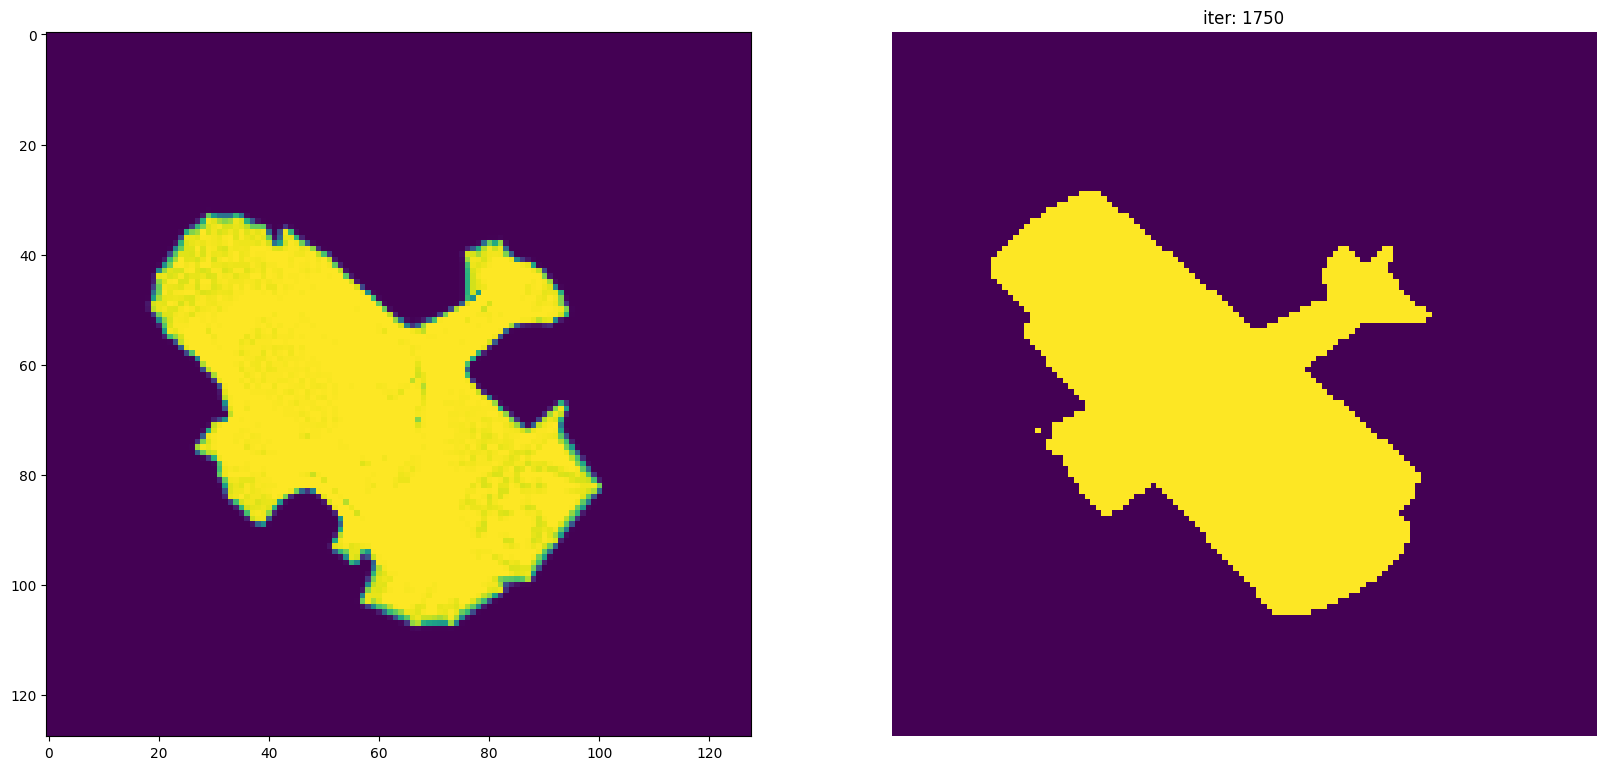

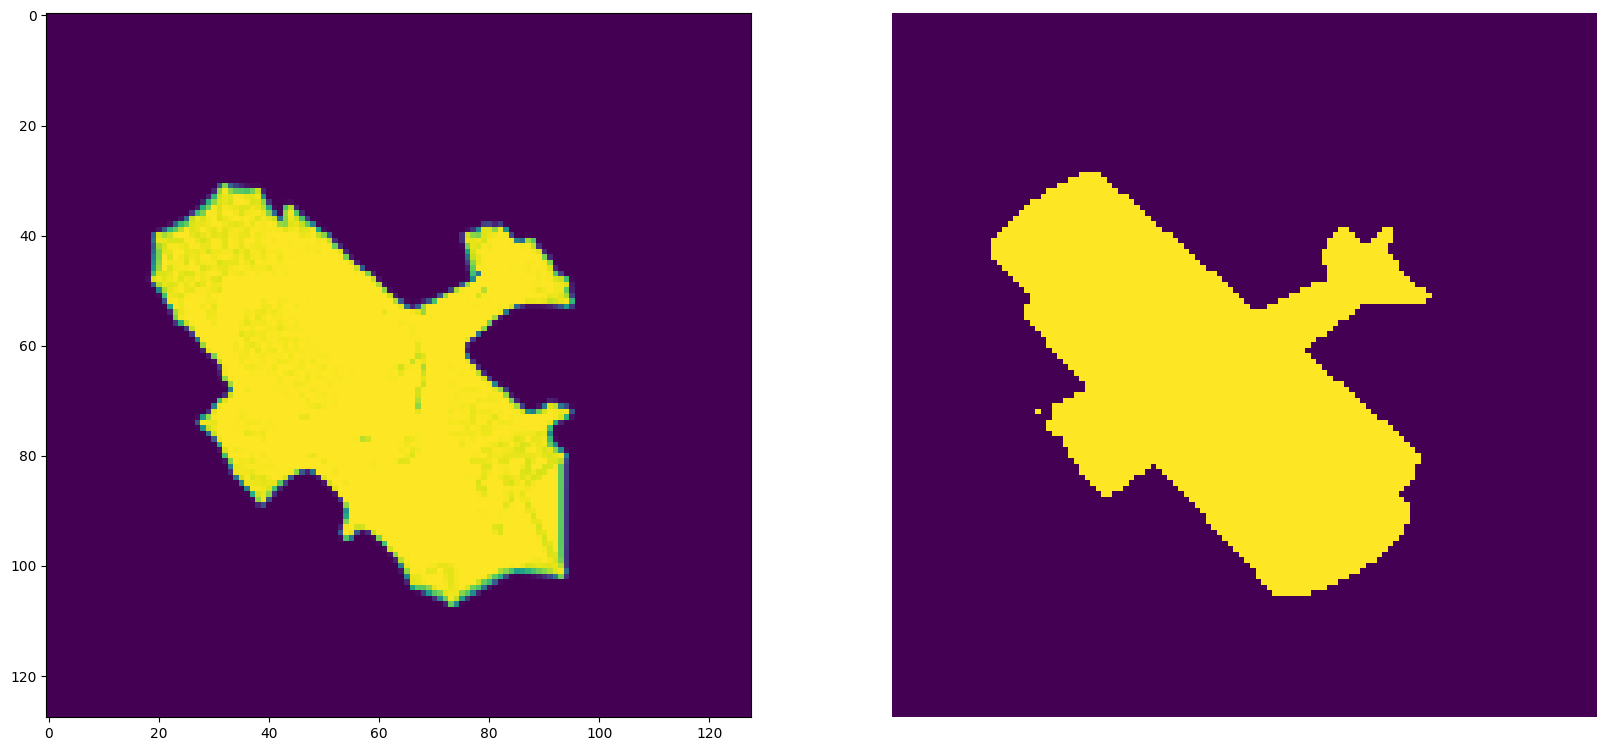

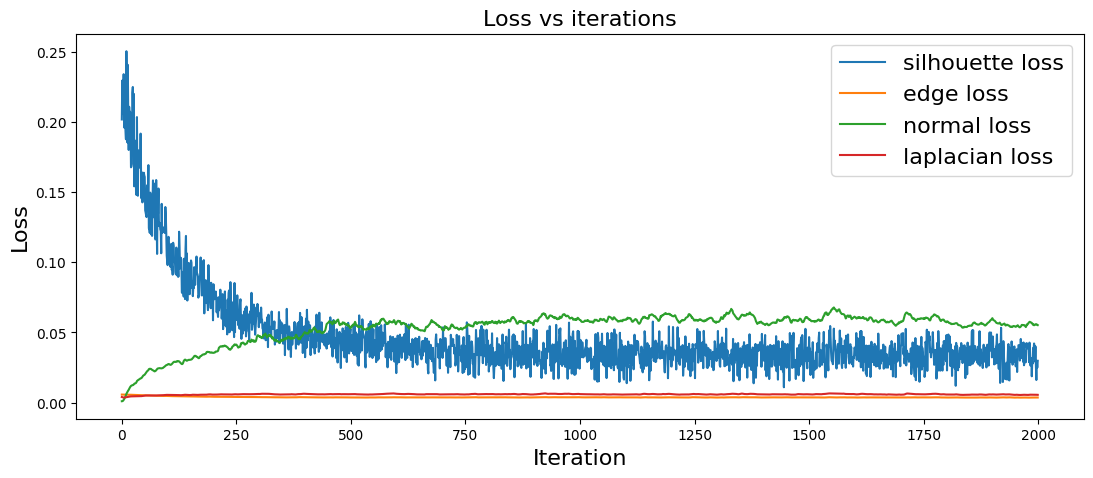

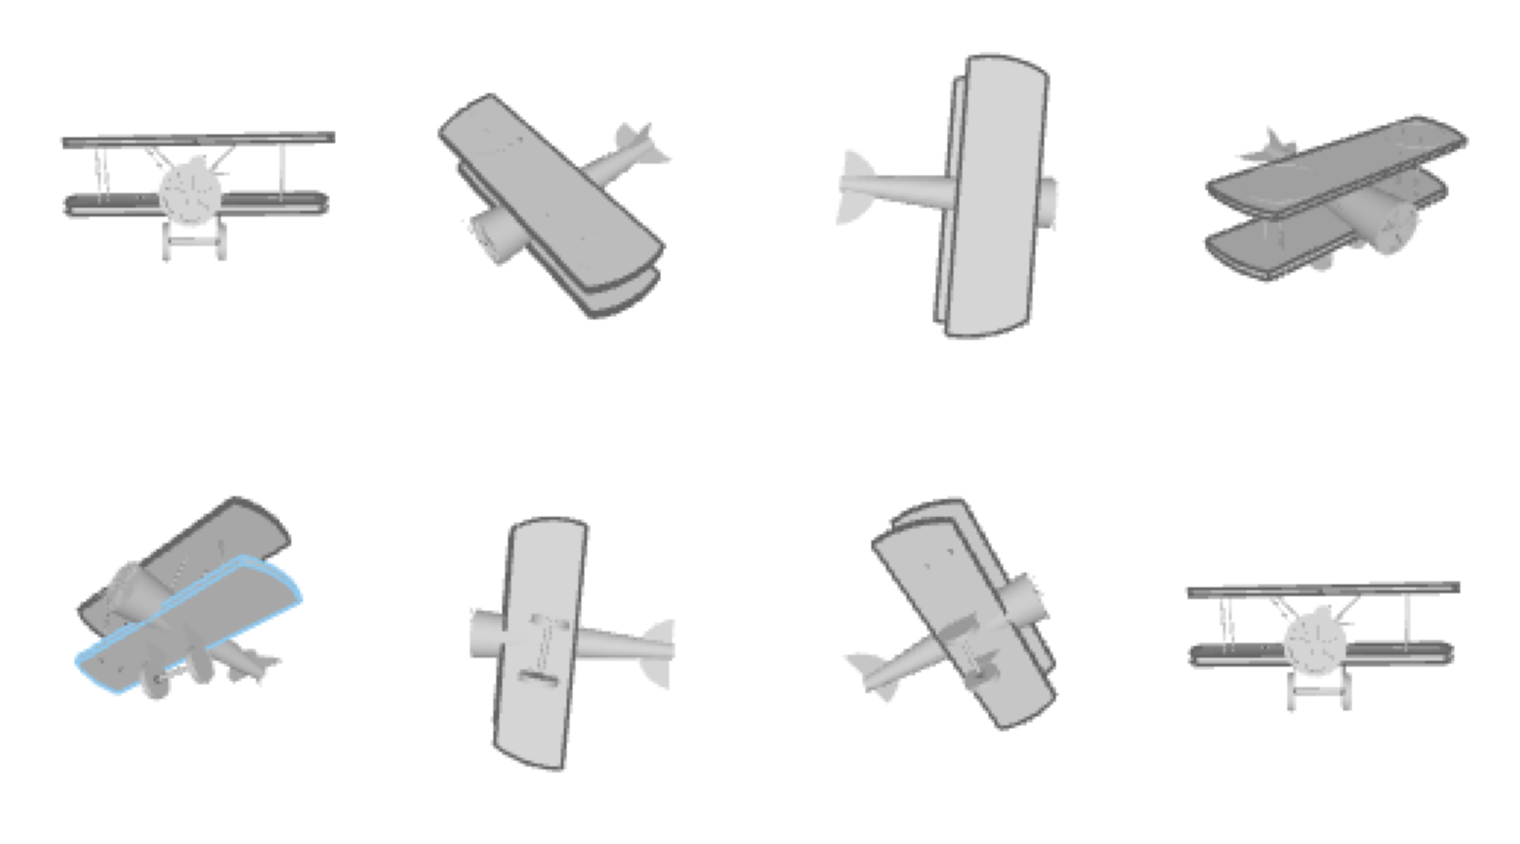

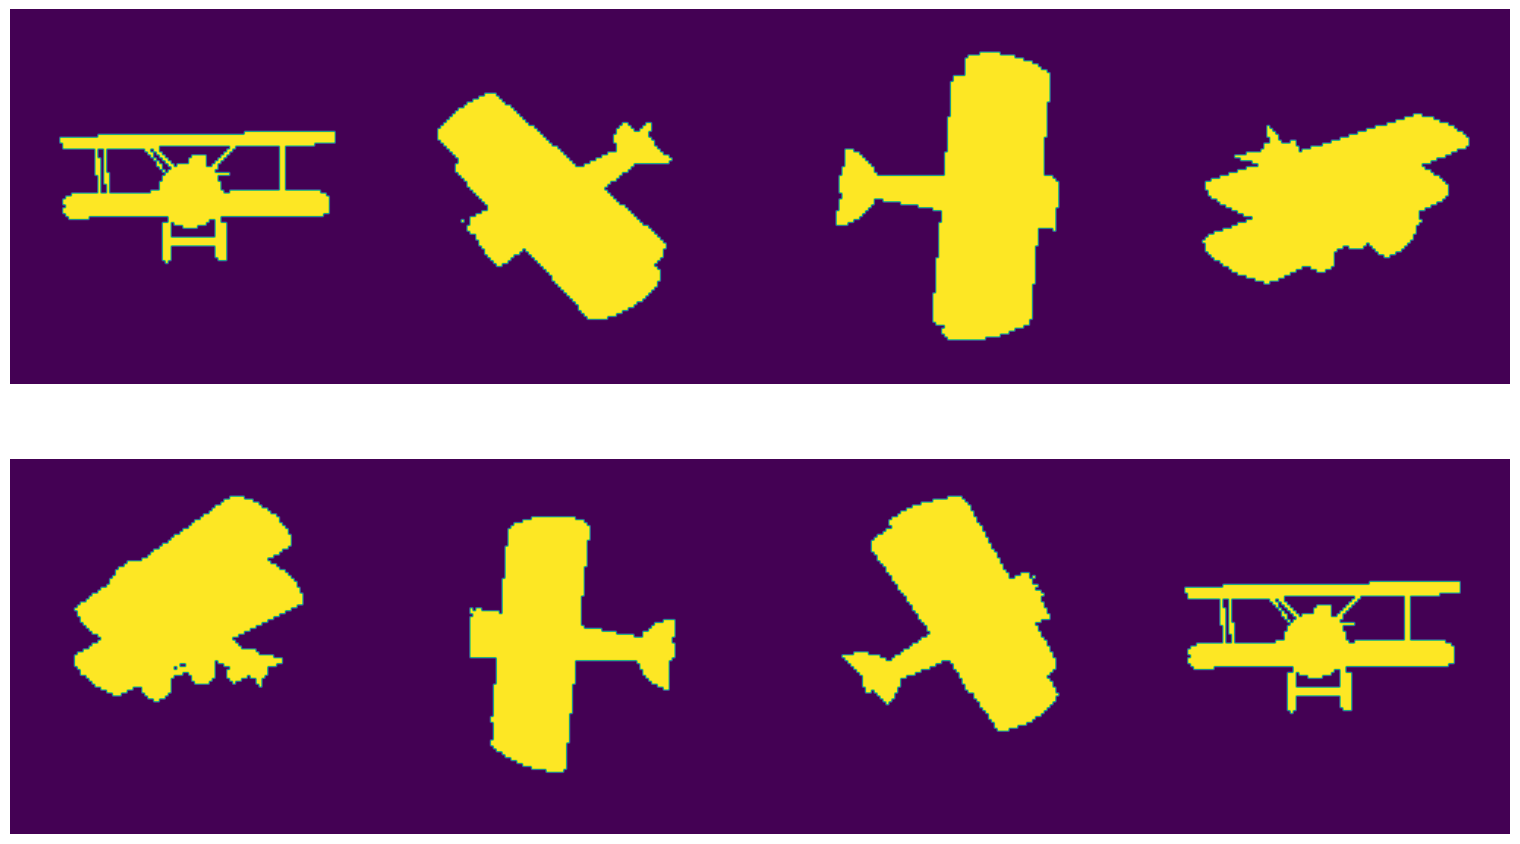

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
anvil.server.wait_forever()